Temperature dependent convection
======


This is a benchmark case of two-dimensional, incompressible, bottom heated, temperature dependent convection. This example is based on the example case 2a in Blankenbach *et al.* 1989 for a single Rayleigh number ($Ra = 10^7$), for more information see the example **1_04_BlankenbachBenchmark_Case2a.ipynb**.

Here a temperature field that is already in equilibrium is loaded and a single Stokes solve is used to get the velocity and pressure fields. A few advection time steps are carried out as a demonstration of the new viscosity function.

**This lesson introduces the concepts of:**
1. material rheologies with functional dependencies

**Problems cover**
1. tracer particle trajectories
2. effect of changing the Rayleigh number and the viscosity constant

**Keywords:** Stokes system, advective diffusive systems, analysis tools, tools for post analysis, rheologies


**References**

1. B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [1]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

Setup parameters
-----

Set simulation parameters for test.

In [2]:
Temp_Min = 0.0
Temp_Max = 1.0
res = 32

**Set physical values in SI units**

In [3]:
alpha = 2.5e-5
rho   = 4e3
g     = 10
dT    = 1e3
h     = 1e6
kappa = 1e-6
eta   = 2.5e19

**Set viscosity function constants as per Case 2a**

In [4]:
Ra   = 1e7
eta0 = 1.0e3

**Input file path**


Set input directory path

In [5]:
inputPath  = 'BBInput/'

Create mesh and finite element variables
------

In [6]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Initial conditions
-------

Load an equilibrium case with 128$\times$128 resolution and $Ra = 10^7$. This can be changed as per **1_03_BlankenbachBenchmark** if required.

In [7]:
meshOld = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                    elementRes  = (128, 128), 
                                    minCoord    = (0., 0.), 
                                    maxCoord    = (1., 1.))
temperatureFieldOld = uw.mesh.MeshVariable( mesh=meshOld, nodeDofCount=1 )        
temperatureFieldOld.load( inputPath + 'tempfield_case2_128_Ra1e7_10000.h5' )

temperatureField.data[:]    = temperatureFieldOld.evaluate( mesh )
temperatureDotField.data[:] = 0.
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.

**Plot initial temperature**


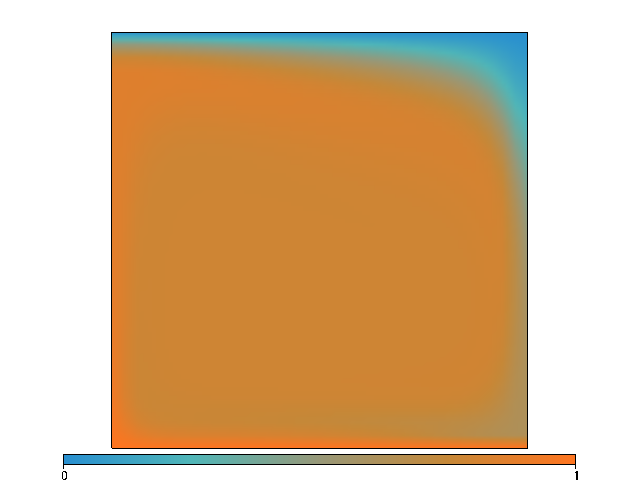

In [8]:
figtemp = glucifer.Figure()
figtemp.append( glucifer.objects.Surface(mesh, temperatureField) )
figtemp.show()

**Boundary conditions**

In [9]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = Temp_Max
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = Temp_Min
    
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = ( jWalls, ) )

Set up material parameters and functions
-----

Setup the viscosity to be a function of the temperature. Recall that these functions and values are preserved for the entire simulation time. 

In [10]:
b = math.log(eta0)
T = temperatureField
fn_viscosity = eta0 * fn.math.exp( -1.0 * b * T )

densityFn = Ra*temperatureField
gravity = ( 0.0, 1.0 )
buoyancyFn = gravity*densityFn

**Plot the initial viscosity**

Plot the viscosity, which is a function of temperature, using the initial temperature conditions set above.


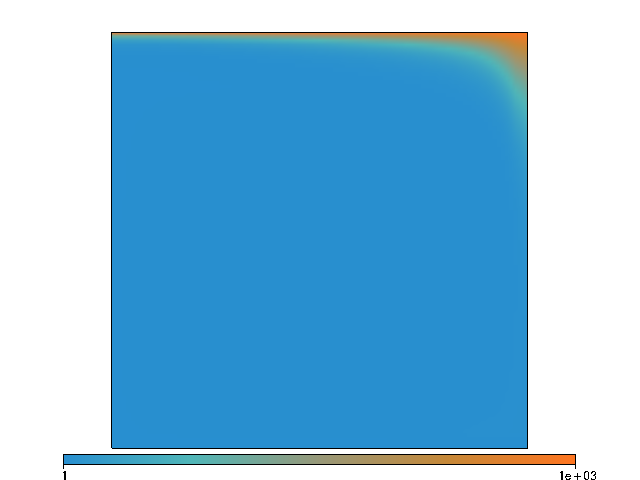

In [11]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Surface(mesh, fn_viscosity) )
figEta.show()

System setup
-----

Since we are using a previously constructed temperature field, we will use a single Stokes solve to get consistent velocity and pressure fields.

**Setup a Stokes system**

In [12]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=fn_viscosity, 
                              fn_bodyforce=buoyancyFn )

**Set up and solve the Stokes system**

In [13]:
solver = uw.systems.Solver(stokesPIC)
solver.solve()

Create an advection system for tracer particle
-----

We require a tracer particle to move in response to the velocity field without affecting it. To do this we create a swarm (more on these later) which is an object made up of particles (usually a lot). Here we will define a swarm consisting of a single particle positioned where we want the tracer particle to begin.

For more information on swarms see example **04_Swarms.ipynb** and for more on tracer particles see **06_Systems.ipynb**.

In [14]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( mesh=mesh )
# Setup an array containing the position data for the tracer
particleCoordinates = np.zeros((1,2))     # 1 is for the number of particles,
                                          # 2 for the number of dimensions for the position.
# Copy position data for the sphere into the newly created array
particleCoordinates[0] = (0.5, 0.9)
# Use this array to add particles to the swarm.
swarm.add_particles_with_coordinates(particleCoordinates)
print('Initial particle coordinates = ({0:.2f}, {1:.2f})'
      .format(swarm.particleCoordinates.data[0][0],swarm.particleCoordinates.data[0][1]))

Initial particle coordinates = (0.50, 0.90)


Create an advection system just to move the tracer particle. It is solved for in the main time loop below.

In [15]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Plot the initial conditions for velocity field and tracer particle
-----


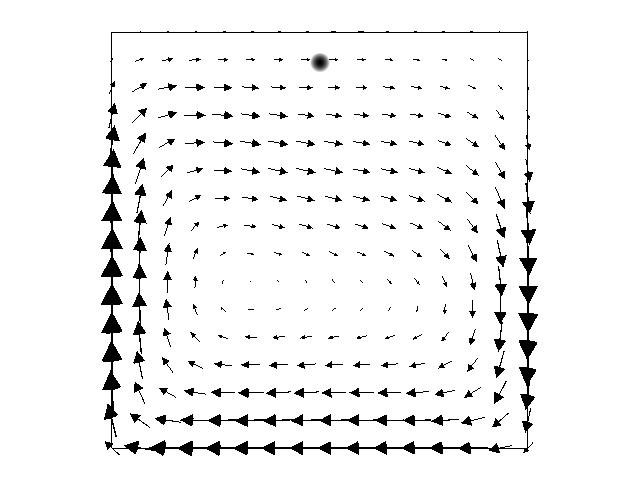

In [16]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.VectorArrows( mesh, velocityField/(1000.0), arrowHead=0.4, scaling=0.1 ) )
fig2.append( glucifer.objects.Points( swarm=swarm, pointSize=20, colourBar = False ) )
fig2.show()

**Create an advective diffusive system**

In [17]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField, fn_diffusivity = 1., 
                                         conditions = [tempBC,], )

Analysis tools
-----

**Nusselt number**

In [18]:
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1], mesh=mesh, integrationType='Surface', 
                                surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
Nu = -nuTop.evaluate()[0]
print('Initial Nusselt number = {0:.3f}'.format(Nu))

Initial Nusselt number = 9.546


**RMS velocity**

In [19]:
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot( velocityField, velocityField ) )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )
Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]
print('Initial Vrms = {0:.3f}'.format(Vrms))

Initial Vrms = 494.622


**Temperature gradients at corners**

In [20]:
def calcQs():
    return (-1.0 * temperatureField.fn_gradient[1].evaluate( (0., 1.))[0][0],
           -1.0 * temperatureField.fn_gradient[1].evaluate( (1., 1.))[0][0],
           -1.0 * temperatureField.fn_gradient[1].evaluate( (1., 0.))[0][0],
           -1.0 * temperatureField.fn_gradient[1].evaluate( (0., 0.))[0][0])

In [21]:
q1, q2, q3, q4 = calcQs()
print('Initial T gradients = {0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}'.format(q1, q2, q3, q4))

Initial T gradients = 16.033, 1.009, 12.096, 0.482


Main simulation loop
-----

Run enough steps to see the tracer particle move around the simulation box in responce to the velocity field. During this time the velocity field will be coming into equilibrium.

In [22]:
time = 0.
step = 0
steps_end = 100
steps_output = 50

# storage arrays for t, x, y for the tracer particle
tVal = []
xVal = []
yVal = []

In [23]:
while step < steps_end:
    # solve Stokes and advection systems
    solver.solve()
    dt = advector.get_max_dt()
    dt = min(dt, advDiff.get_max_dt())
    # Advect using this timestep size   
    if step == 0:
        dt = 0.
    advector.integrate(dt)
    advDiff.integrate(dt)
    # Calculate the RMS velocity and Nusselt number.
    Vrms = math.sqrt( v2sum_integral.evaluate()[0] )/volume_integral.evaluate()[0]
    Nu = -nuTop.evaluate()[0]
    q1, q2, q3, q4 = calcQs()
    # save tracer time and position
    tVal.append(time)
    xVal.append(swarm.particleCoordinates.data[0][0])
    yVal.append(swarm.particleCoordinates.data[0][1])
    # output to screen
    if step%steps_output == 0:
        print('Step {0:2d}: Vrms = {1:.3f}; Nu = {2:.3f}; q1 = {3:.3f}; q2 = {4:.3f}; q3 = {5:.3f}; q4 = {6:.3f}'
              .format(step, Vrms, Nu, q1, q2, q3, q4))
    time += dt
    step += 1

Step  0: Vrms = 494.622; Nu = 9.546; q1 = 16.033; q2 = 1.009; q3 = 12.096; q4 = 0.482
Step 50: Vrms = 507.573; Nu = 9.532; q1 = 16.049; q2 = 1.008; q3 = 12.428; q4 = 0.337


Comparison of benchmark values
-----

Compare values from Underworld against those from Blankenbach *et al.* 1989 for case 2a with $Ra = 10^7$ **using a resolution of 128$^2$**: 

| $Ra$   | $Nu$    | $v_{rms}$|  $q_1$   |  $q_2$  |  $q_3$  |  $q_4$   | 
|:------:|:--------:|:-------:|:--------:|:-------:|:-------:|:--------:|
| 10$^7$ | 10.0660 | 480.4    | 17.53136 | 1.00851 | 26.8085 | 0.497380 | 

In [24]:
print('Step {0:2d}: Vrms = {1:.3f}; Nu = {2:.3f}; q1 = {3:.3f}; q2 = {4:.3f}; q3 = {5:.3f}; q4 = {6:.3f}'
    .format(step, Vrms, Nu, q1, q2, q3, q4))

Step 100: Vrms = 520.987; Nu = 9.528; q1 = 16.088; q2 = 1.006; q3 = 12.304; q4 = 0.321


Plot current particle position
---


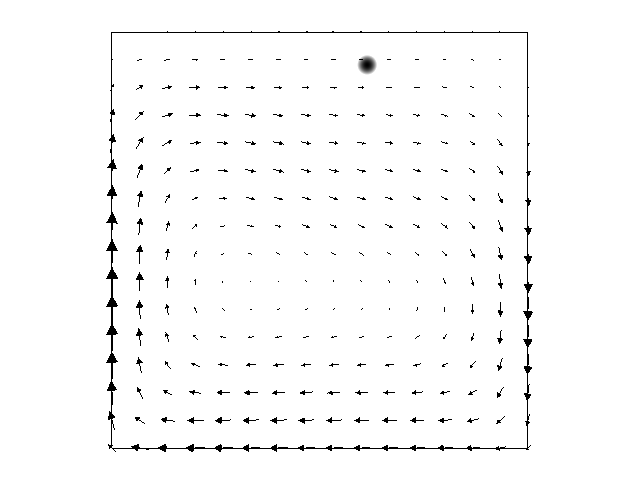

In [25]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.VectorArrows( mesh, velocityField/(2000.0), arrowHead=0.4, scaling=0.1 ) )
fig2.append( glucifer.objects.Points( swarm=swarm, pointSize=20, colourBar = False ) )
fig2.show()

Plot the tracer particle's movement
----

Initial position: (0.500, 0.900)
Final position:   (0.606, 0.895)


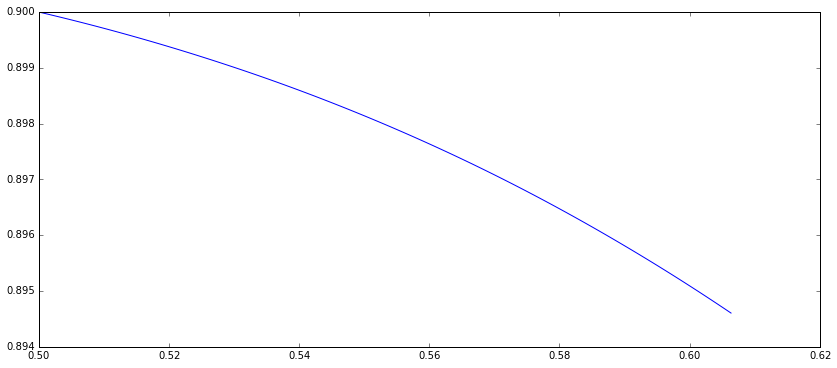

In [26]:
print('Initial position: ({0:.3f}, {1:.3f})'.format(xVal[0], yVal[0]))
print('Final position:   ({0:.3f}, {1:.3f})'.format(xVal[-1], yVal[-1]))

pylab.rcParams[ 'figure.figsize'] = 14, 6
pyplot.plot(xVal, yVal)
pyplot.show()

Problems
----

**Problem 1:** What do other tracer particle trajectories look like starting from different positions?

**Problem 2:** What is the effect of changing $Ra$ and the viscosity constant $\eta_0$ on the path of the test particle?

**Problem 3:** Produce a figure to demonstrate this.